<a href="https://colab.research.google.com/github/lmendezayl/uba-ldd-ic/blob/main/notebooks/clase20_ldd_pca_aplicaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn

import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

import ipywidgets as widgets
!pip install ipympl
import ipympl

## Un ejemplo: análisis de espectrometrías

## Descripción del conjunto de datos

Este conjunto de datos proviene del trabajo de **Lemberge et al. (2000)** y contiene mediciones realizadas mediante **análisis de microsonda electrónica con rayos X (EPXMA, por sus siglas en inglés: Electron Probe X-ray Microanalysis)**. Las muestras analizadas corresponden a fragmentos de vasos de vidrio **arqueológicos de los siglos XVI y XVII**.

El objetivo de este tipo de análisis es identificar la **composición química** del vidrio mediante la medición de la **intensidad de emisión de rayos X** en diferentes longitudes de onda, las cuales están asociadas con los distintos elementos químicos presentes en las muestras. Este conjunto de datos también fue utilizado en el estudio de **Hubert et al. (2005)**, en el contexto del análisis de datos multivariados.

---

## Formato de los datos

El conjunto está organizado en forma de un **data frame** con:

- **180 observaciones** (una por cada fragmento de vidrio analizado),
- y **750 variables**.

Cada variable representa la **intensidad registrada en una longitud de onda específica** durante el análisis EPXMA. Estas variables están etiquetadas como `V1`, `V2`, ..., `V750`.

In [ ]:
dfx = pd.read_csv("glass-espectros.csv").rename(columns={"Unnamed: 0": "id"}).set_index("id")
dfx

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V741,V742,V743,V744,V745,V746,V747,V748,V749,V750
id,,,,,,,,,,,,,,,,,,,,,
1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,40.80,38.40,41.80,41.80,50.60,42.80,47.00,40.6,41.6,41.6
2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,41.60,43.60,42.40,39.60,42.80,43.20,44.80,43.8,44.4,37.2
3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,50.60,41.00,45.60,47.80,47.00,44.20,49.80,40.6,40.4,42.0
4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,45.75,45.75,42.75,40.75,42.75,46.25,49.25,46.5,47.0,42.5
5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,42.20,41.40,39.60,44.80,43.00,44.40,45.60,43.4,40.0,40.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,45.60,48.80,46.80,38.40,44.40,47.20,46.00,47.6,38.8,47.2
177,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,42.80,42.80,42.60,37.80,45.80,48.00,46.40,46.4,41.4,44.8
178,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,40.40,46.00,44.00,40.40,44.40,45.00,40.20,43.0,44.4,43.0


In [ ]:
np.argmin(dfx["V167"])

np.int64(43)

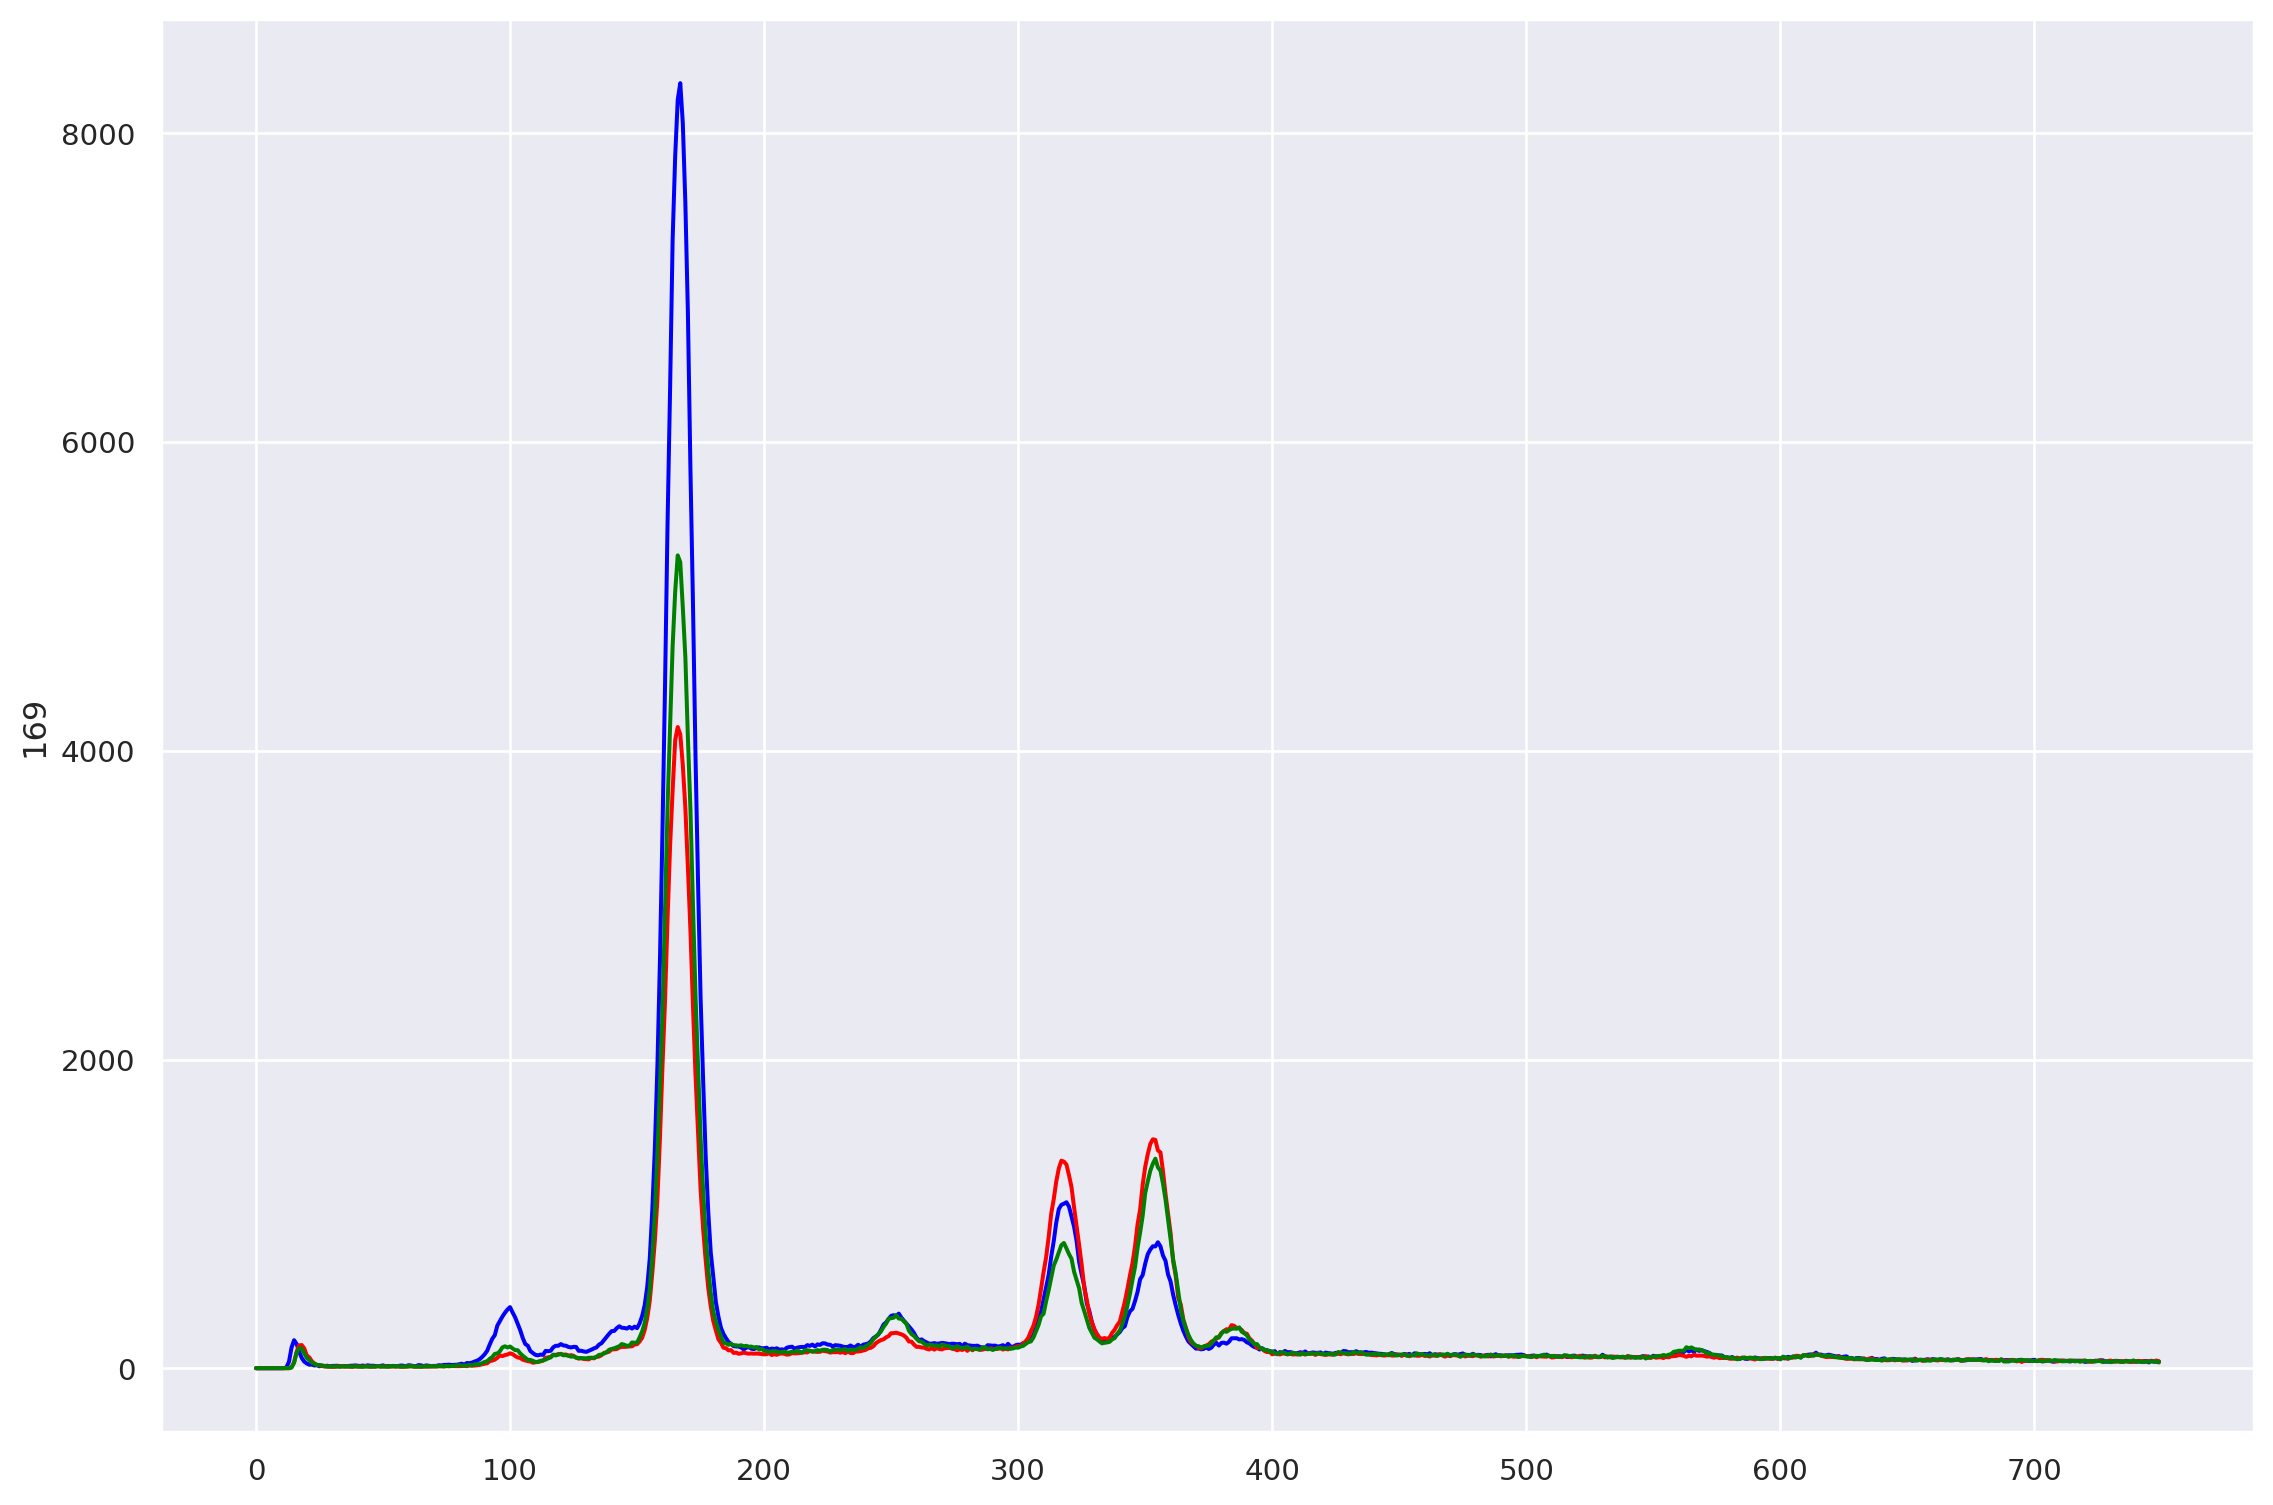

In [ ]:
# Podemos graficar las intensidades para algunas vasijas
(
    so.Plot(x = np.arange(0,750), y = dfx.loc[169])
    .add(so.Line(color = "blue"))
    .add(so.Line(color = "red"), y = dfx.loc[43])
    .add(so.Line(color = "green"), y = dfx.loc[2])
    .layout(size=(12,8))
)

In [ ]:
# Puede ser más simple para graficar juntar todas las intensidades en una sola variable y luego agrupar por id
# Usamos el comando melt
data = dfx.reset_index().melt(id_vars="id", var_name="freq", value_name="ampl")
data["freq"] = data.freq.str.replace("V", "").astype(int)
data["id"] = data.id.astype("str")
data

,id,freq,ampl
0,1,1,0.1
1,2,1,0.1
2,3,1,0.1
3,4,1,0.1
4,5,1,0.1
...,...,...,...
134995,176,750,47.2
134996,177,750,44.8
134997,178,750,43.0
134998,179,750,47.2


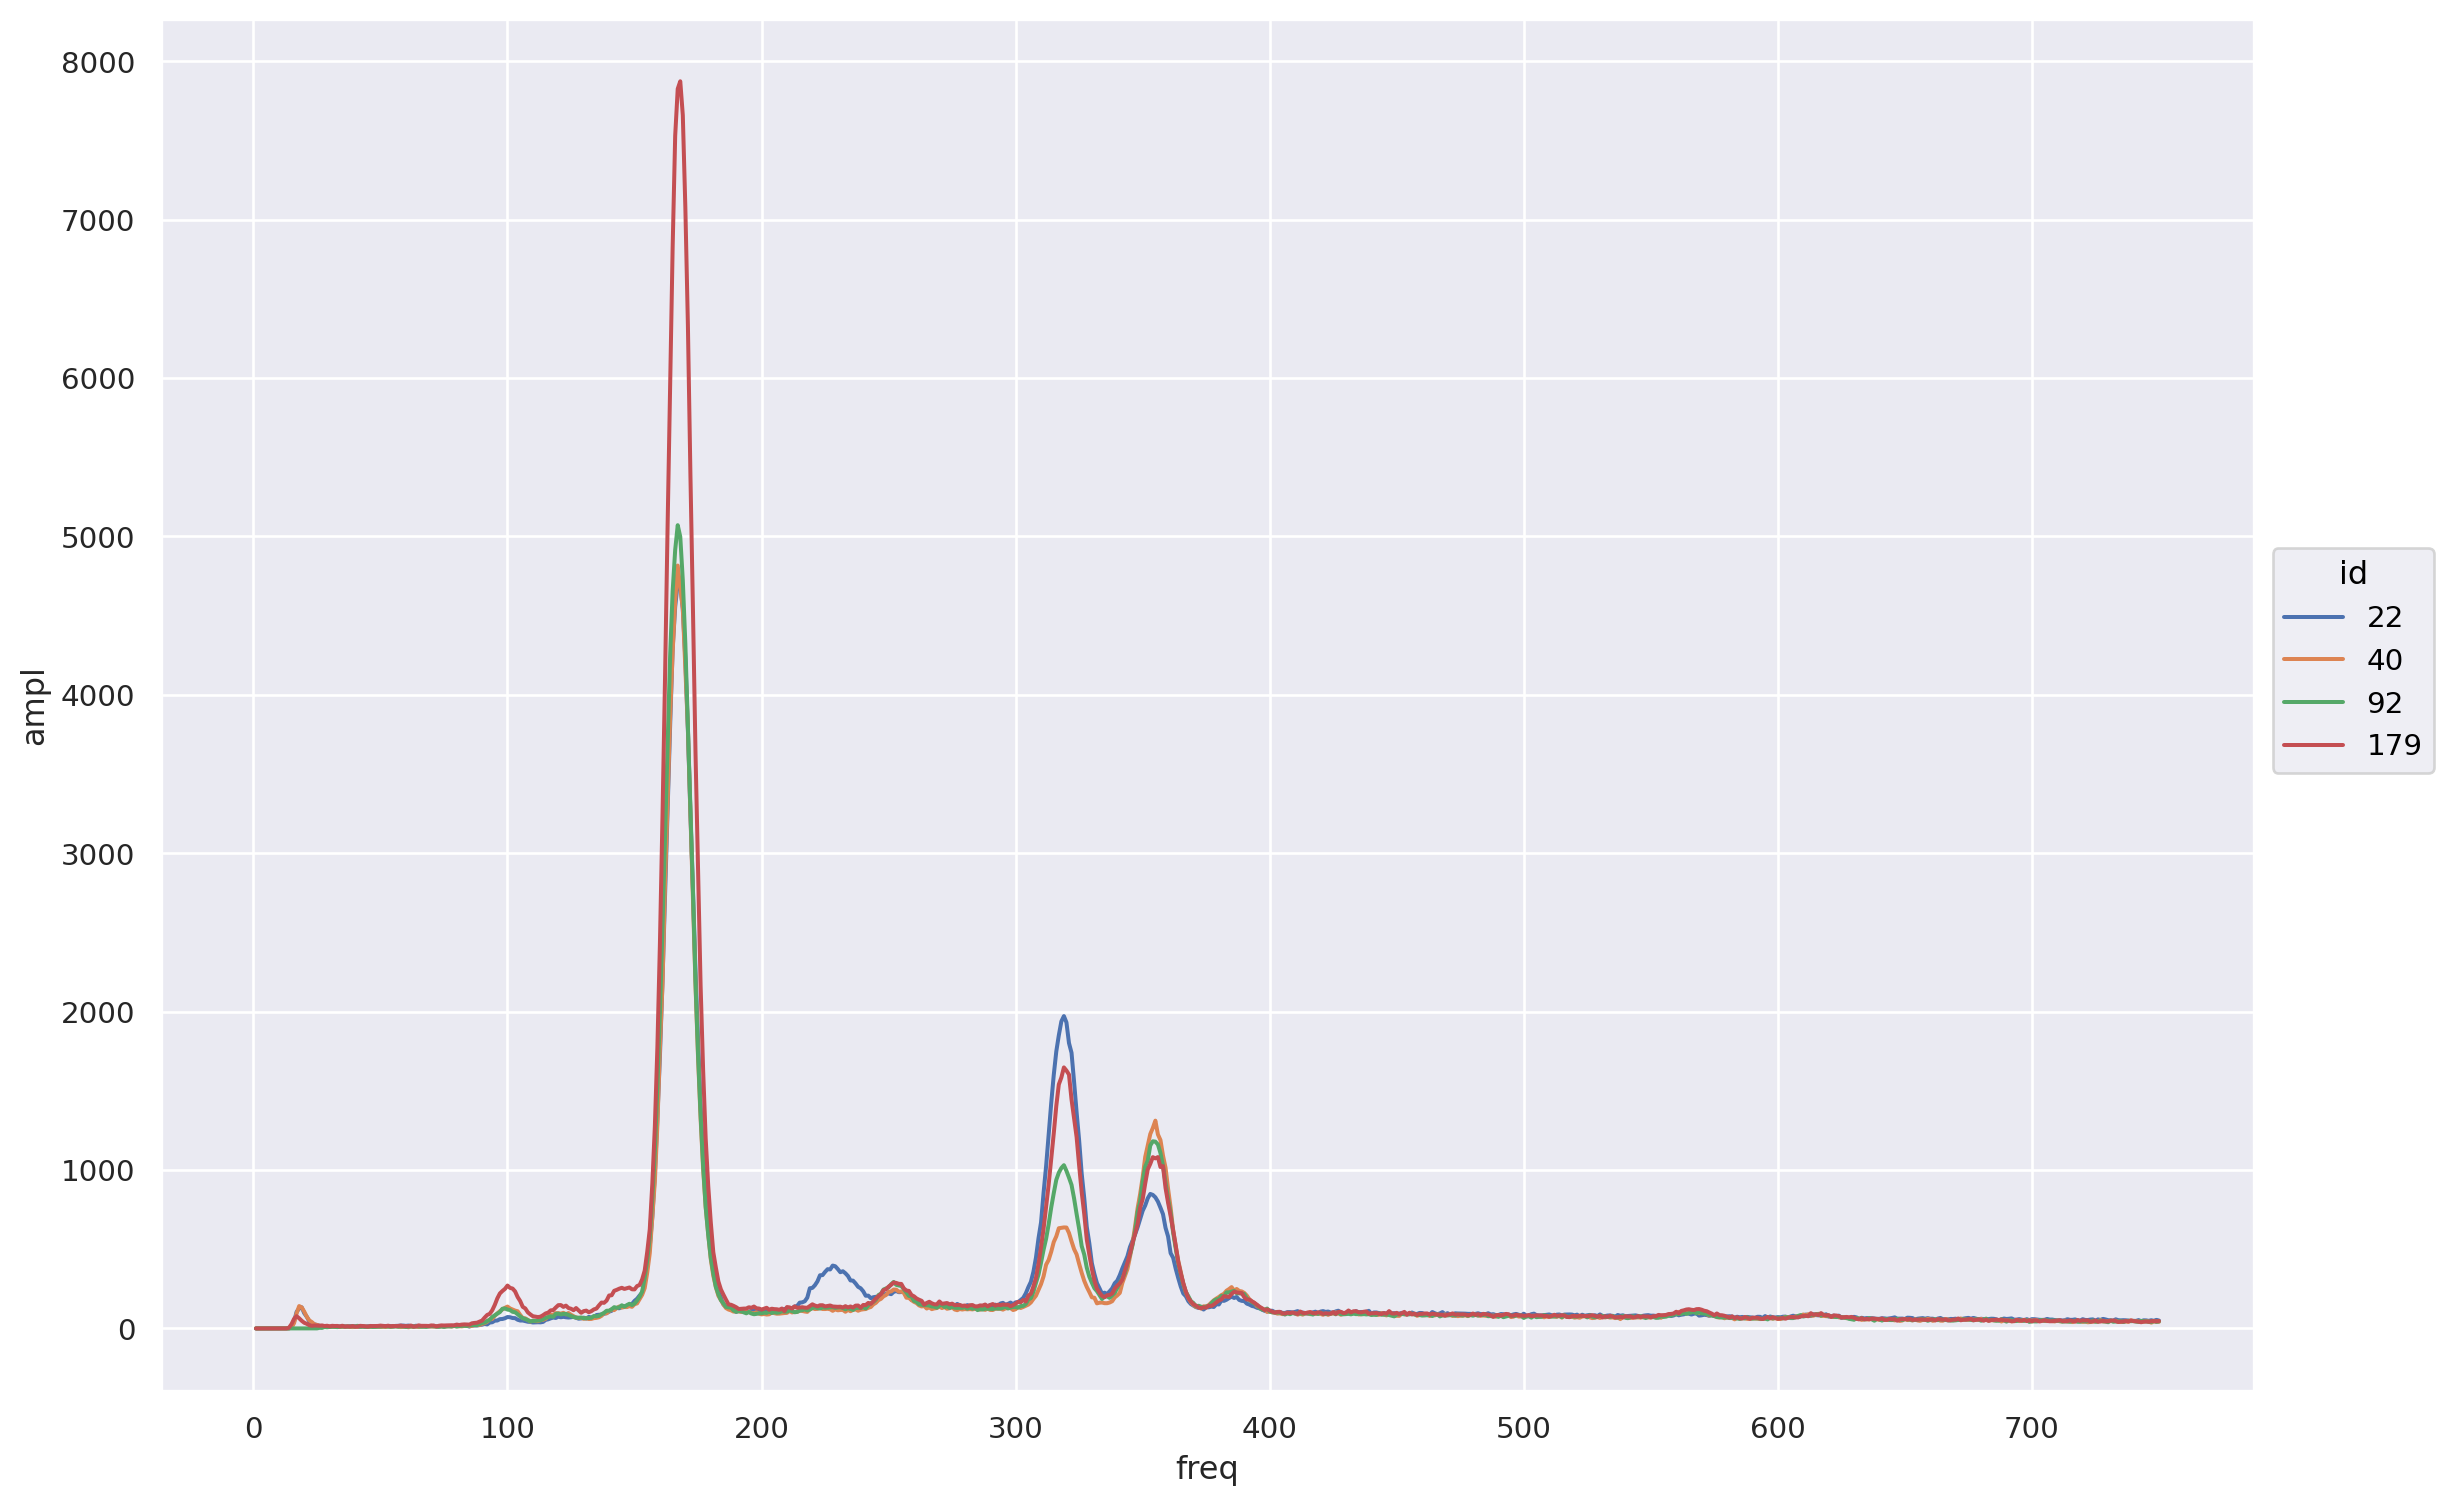

In [ ]:
# Ahora graficamos los espectros de algunas vasijas agrupando por "id"
espectros = ["22", "40", "92", "179"]
(
    so.Plot(data = data[data.id.isin(espectros)], x = "freq", y = "ampl", color='id')  #
    .add(so.Line())
    .layout(size=(12,8))
)

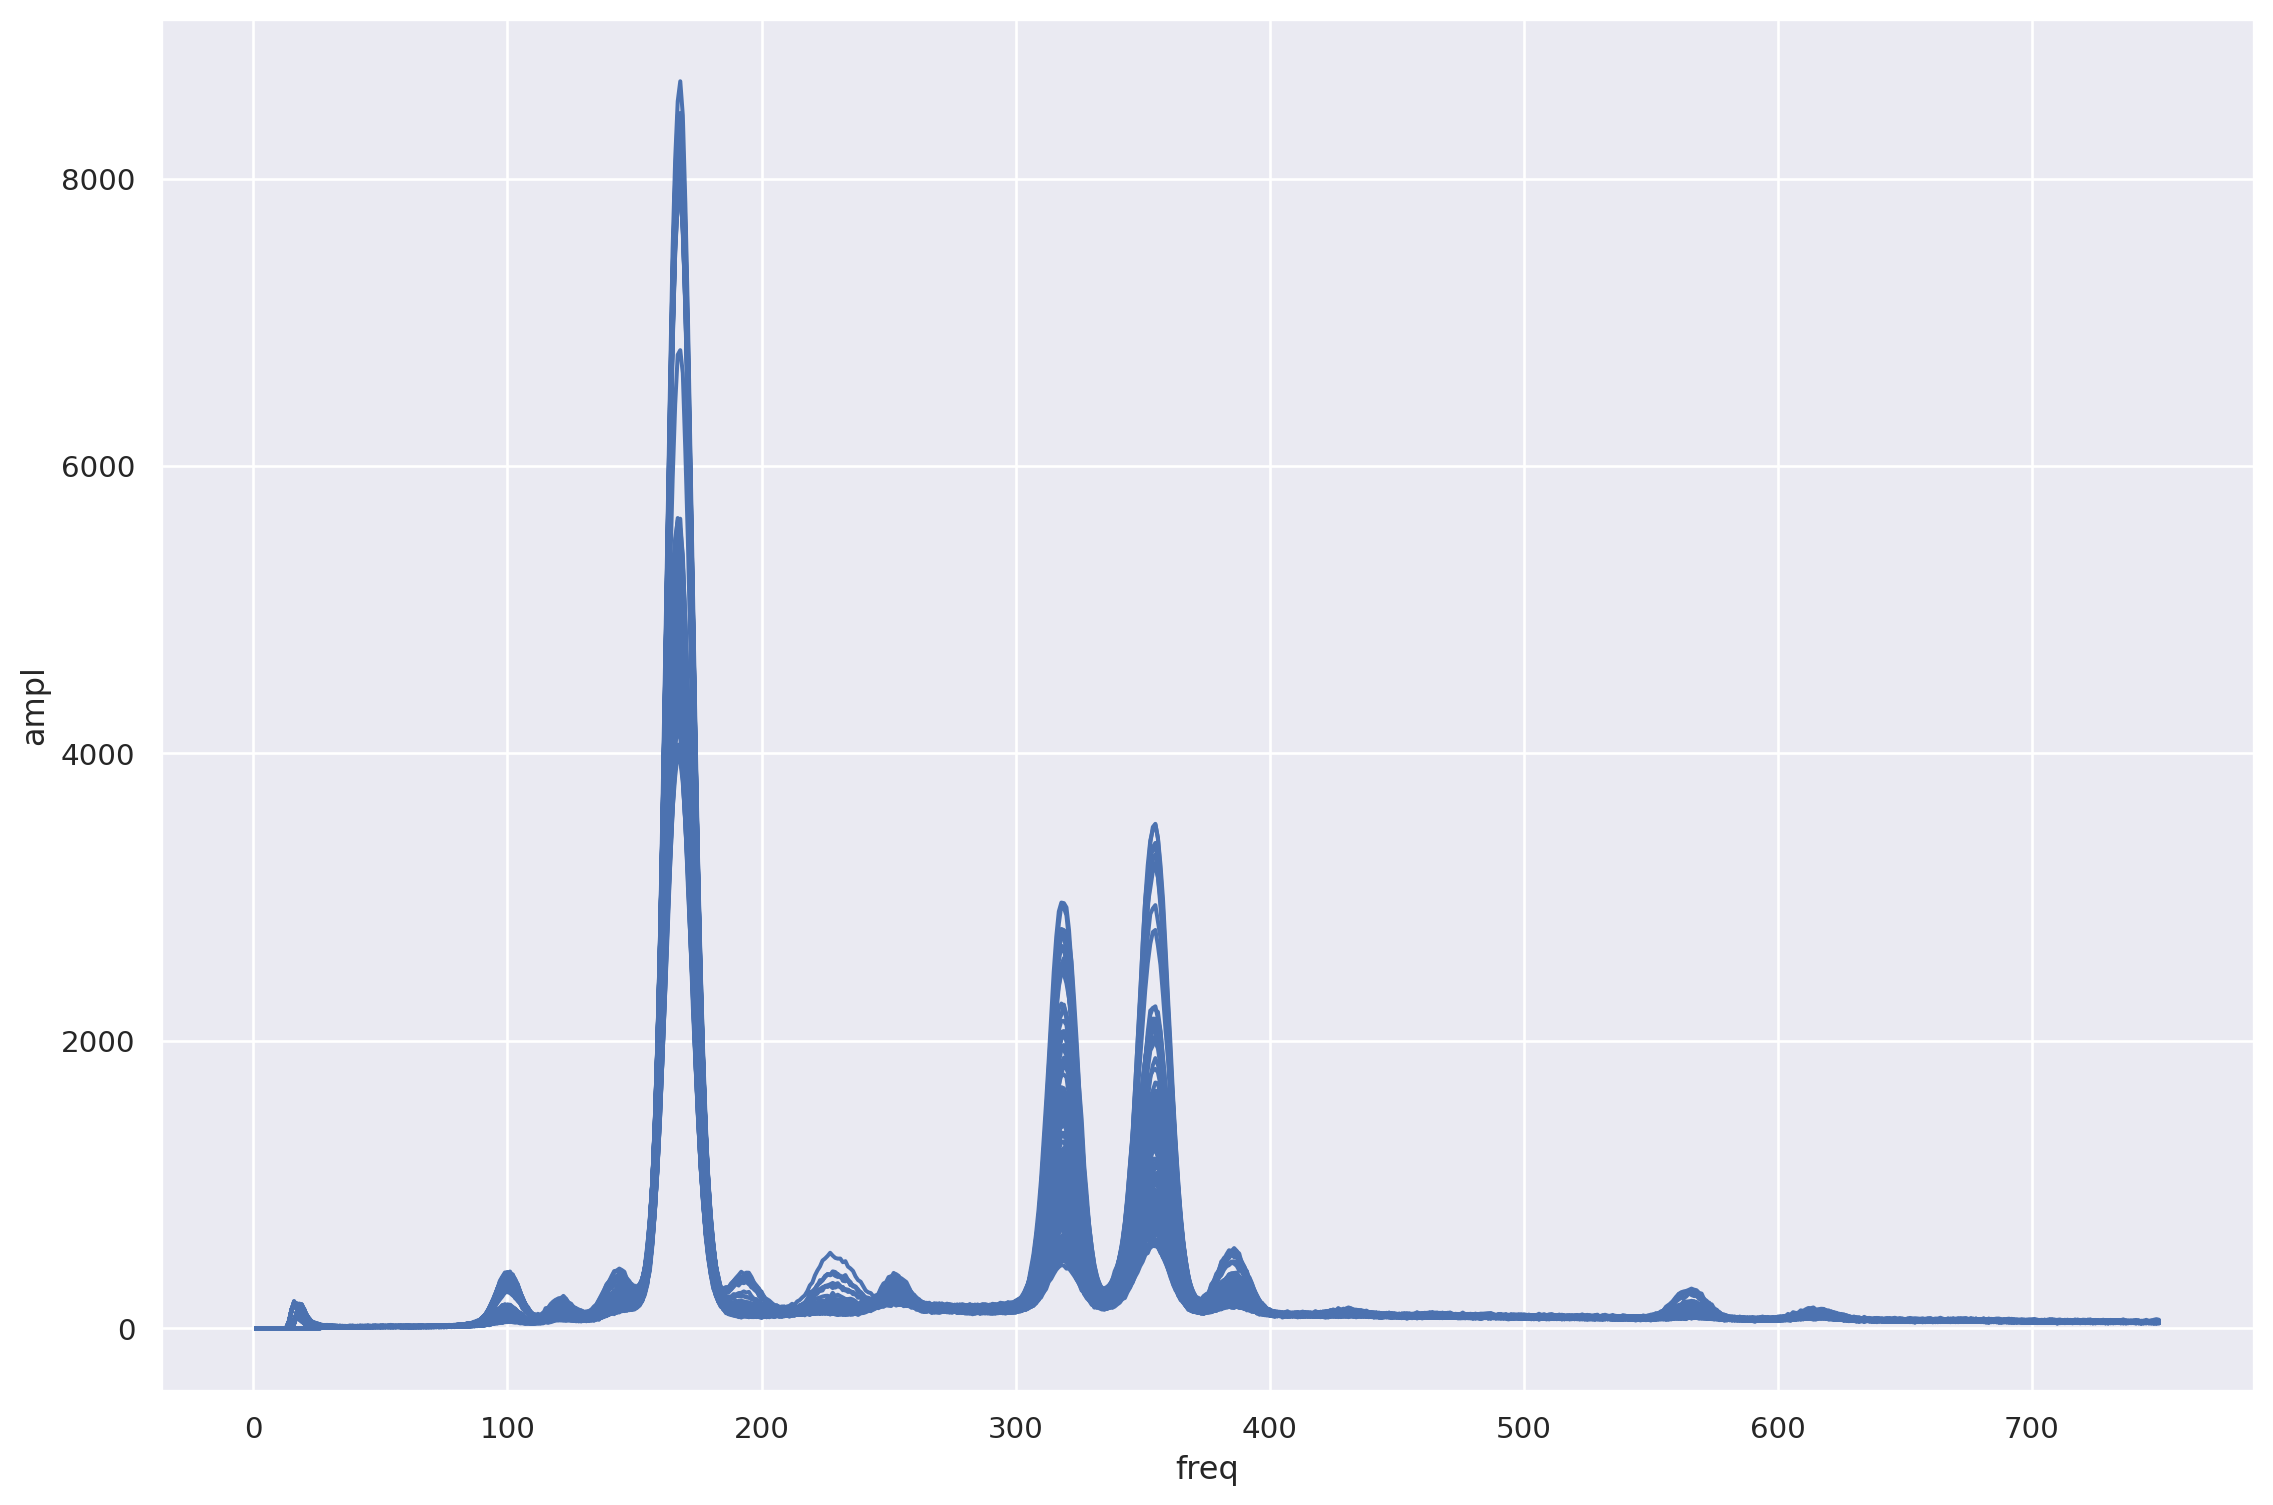

In [ ]:
# O graficamos todas las vasijas
(
    so.Plot(data = data, x = "freq", y = "ampl", group = "id")
    .add(so.Line(), legend = False)
    .layout(size=(12,8))
)

In [ ]:
V1 = "V" + str(np.argmax(dfx.loc[180]))
V2 = "V" + str(np.argmax(dfx.loc[180], 2))


'V167'

## Análisis de componentes principales
Queremos resumir la información de las amplitudes en pocas variables.

Mirando el gráfico, ¿cuántas variables consideran apropiadas para resumir la información?


### Primero: clusters
Vamos a agrupar a las vasijas en clusters según su espectro.

**Pregunta:** Entre K-mean y DB-scan cuál metodo consideran que puede resultar más adecuado en este caso?

<details>
  <summaryRespuestad</summary>
Resumen:

- DB-scan significa Density-Based Spatial Clustering of Applications with Noise. Se utiliza principalmente para datos "espaciales": mapas, imágenes, etc. No es el caso de este ejemplo.
- K-means se utiliza cuando los clusters son "esféricos". Esta hipótesis es razonable cuando pensamos que los clusters corresponden a rangos de las variables. Por ejemplo, en especies de animales, un cluster puede corresponder a peso entre 100 y 200g y longitud entre 1m y 2m.

A priori, K-means resulta más apropiado en este ejemplo porque podemos pensar que los distintos tipos de materiales corresponden a rangos de amplitud de ciertas frecuencias.

</details>

Aplicamos el **método del codo** para ver cuántos clusters tomar.

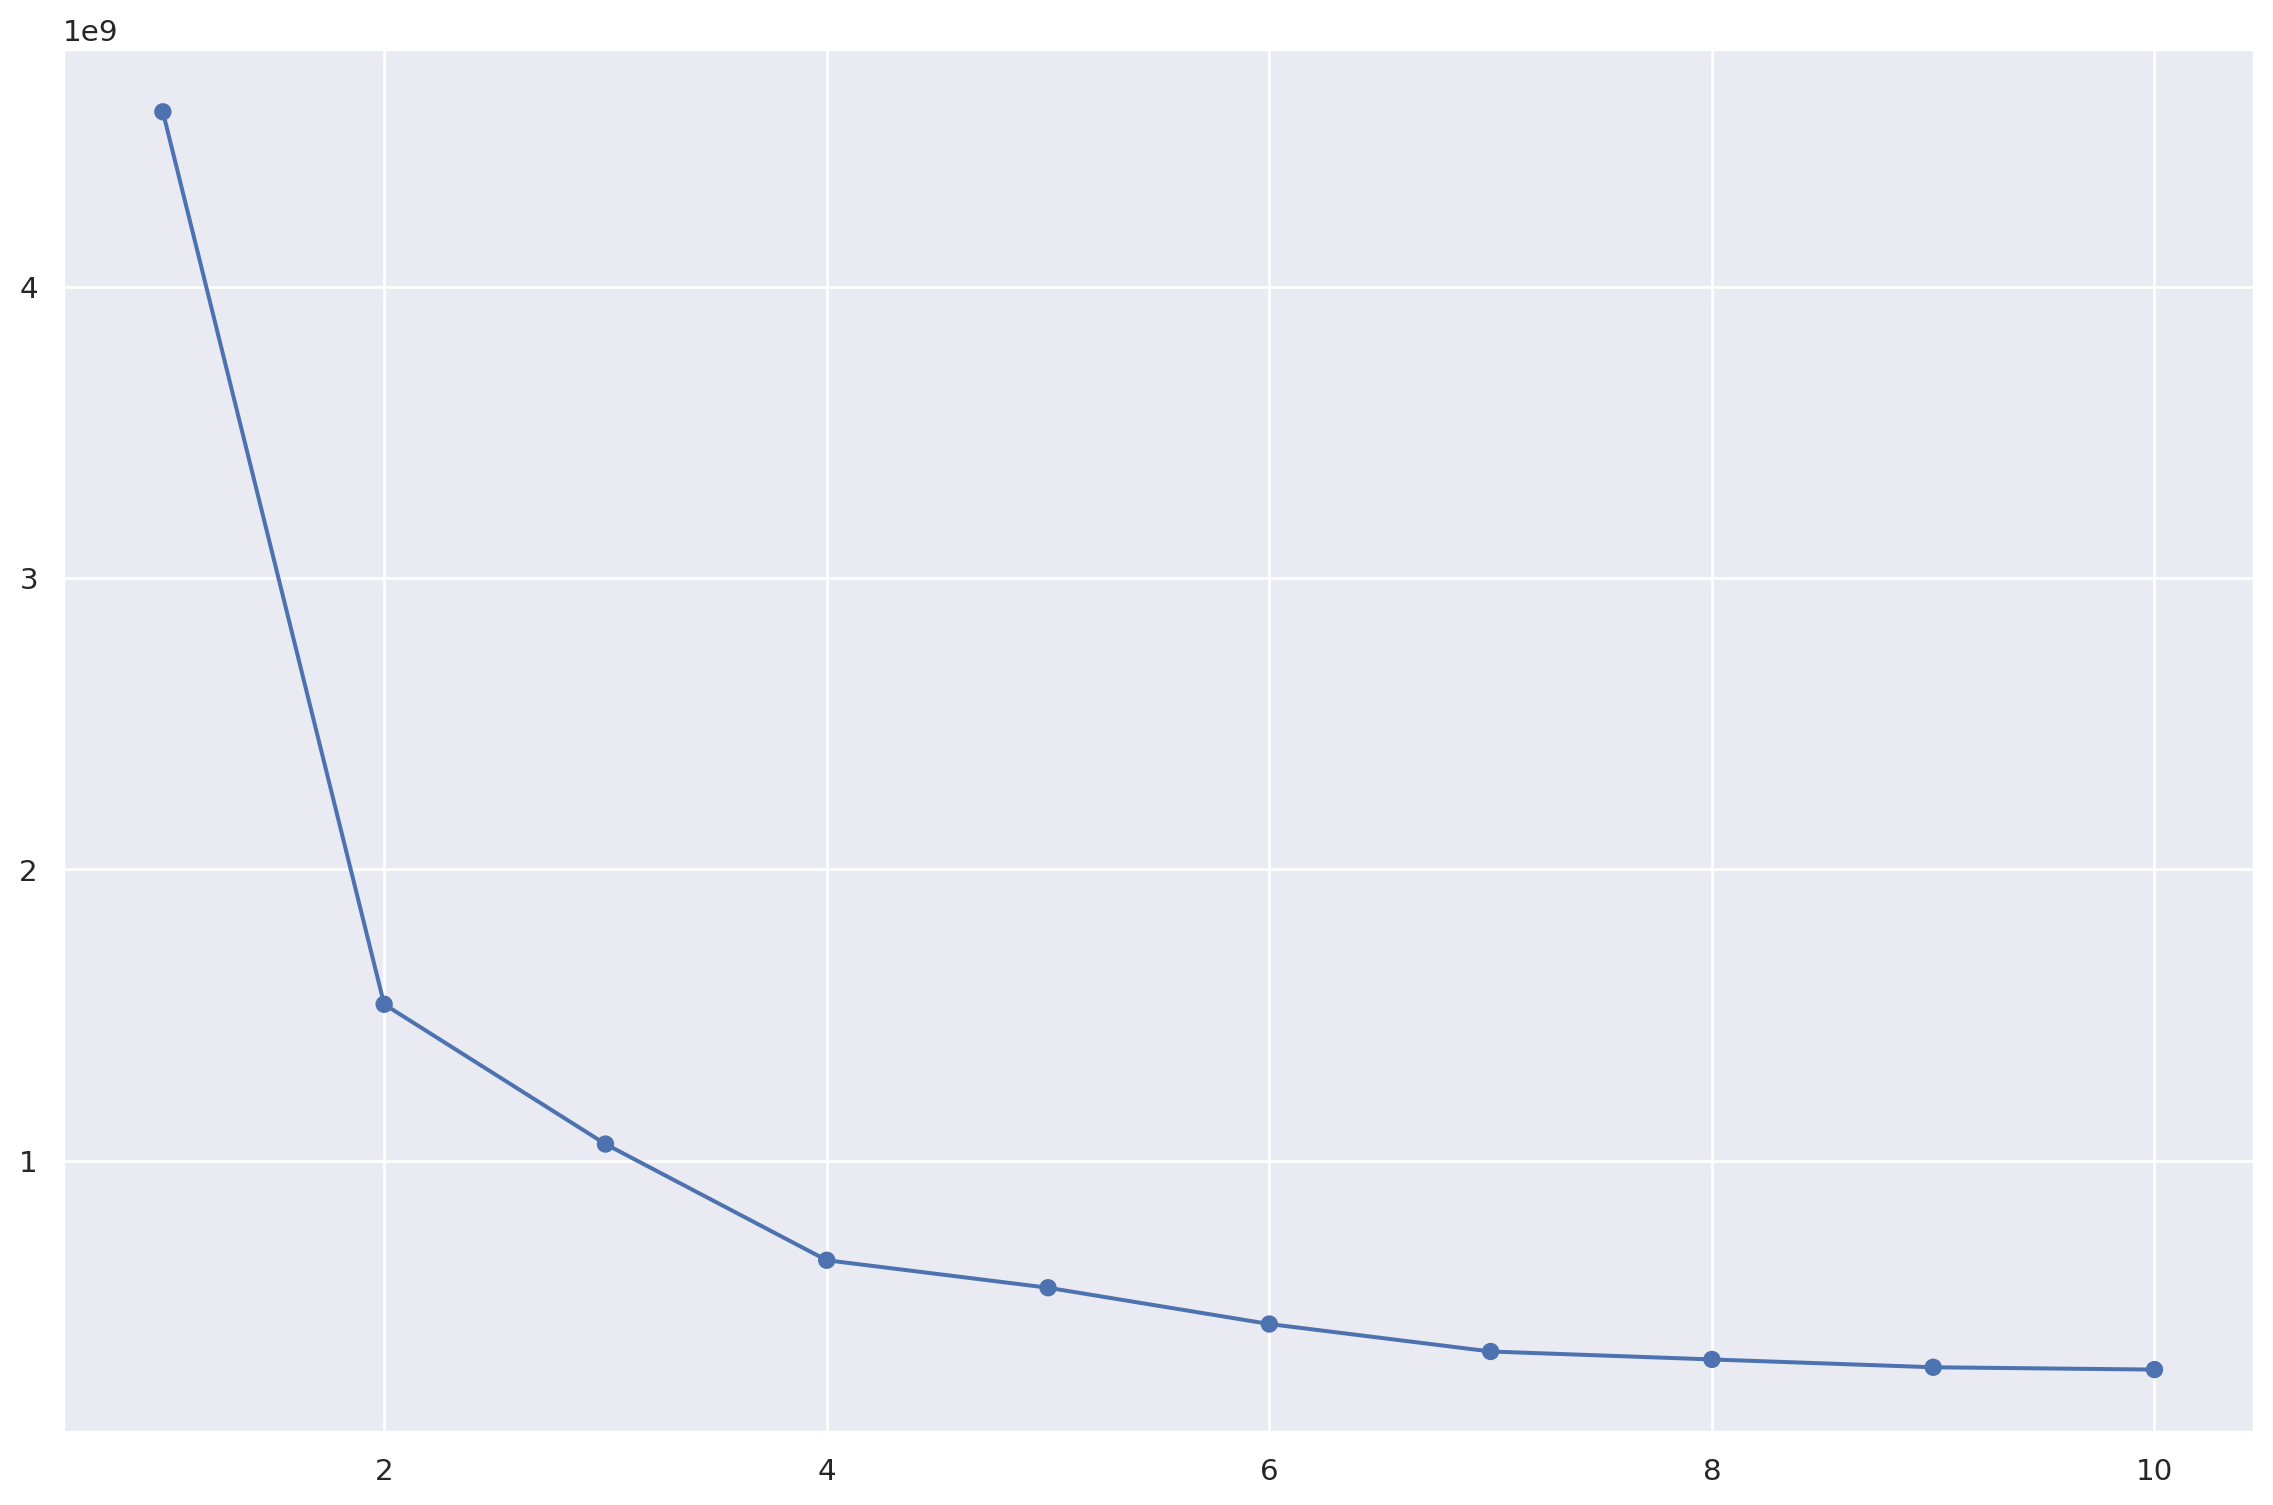

In [ ]:
# Calculamos la "inercia" para k=1 hasta k=10
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(dfx)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
(
    so.Plot(x = k_values, y = inertias)
    .add(so.Line())
    .add(so.Dot())
    .layout(size=(12,8))
)

Vemos un cambio de pendiente (codo) en $k = 4$.

Esto coincide con los resultados del trabajo de donde tomamos los datos.

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(dfx)
labels = kmeans.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=int32)

Como podemos visualizar los clusters? A qué datos de las vasijas corresponden los clusters?
Utilizamos las frecuencias que a ojo parecen las más relevantes.

In [ ]:
import scipy.signal as sig

sig.find_peaks(dfx.loc[179], height=700)

(array([167, 318, 353, 355, 357]),
 {'peak_heights': array([7873.8, 1648. , 1081.4, 1082. , 1025. ])})

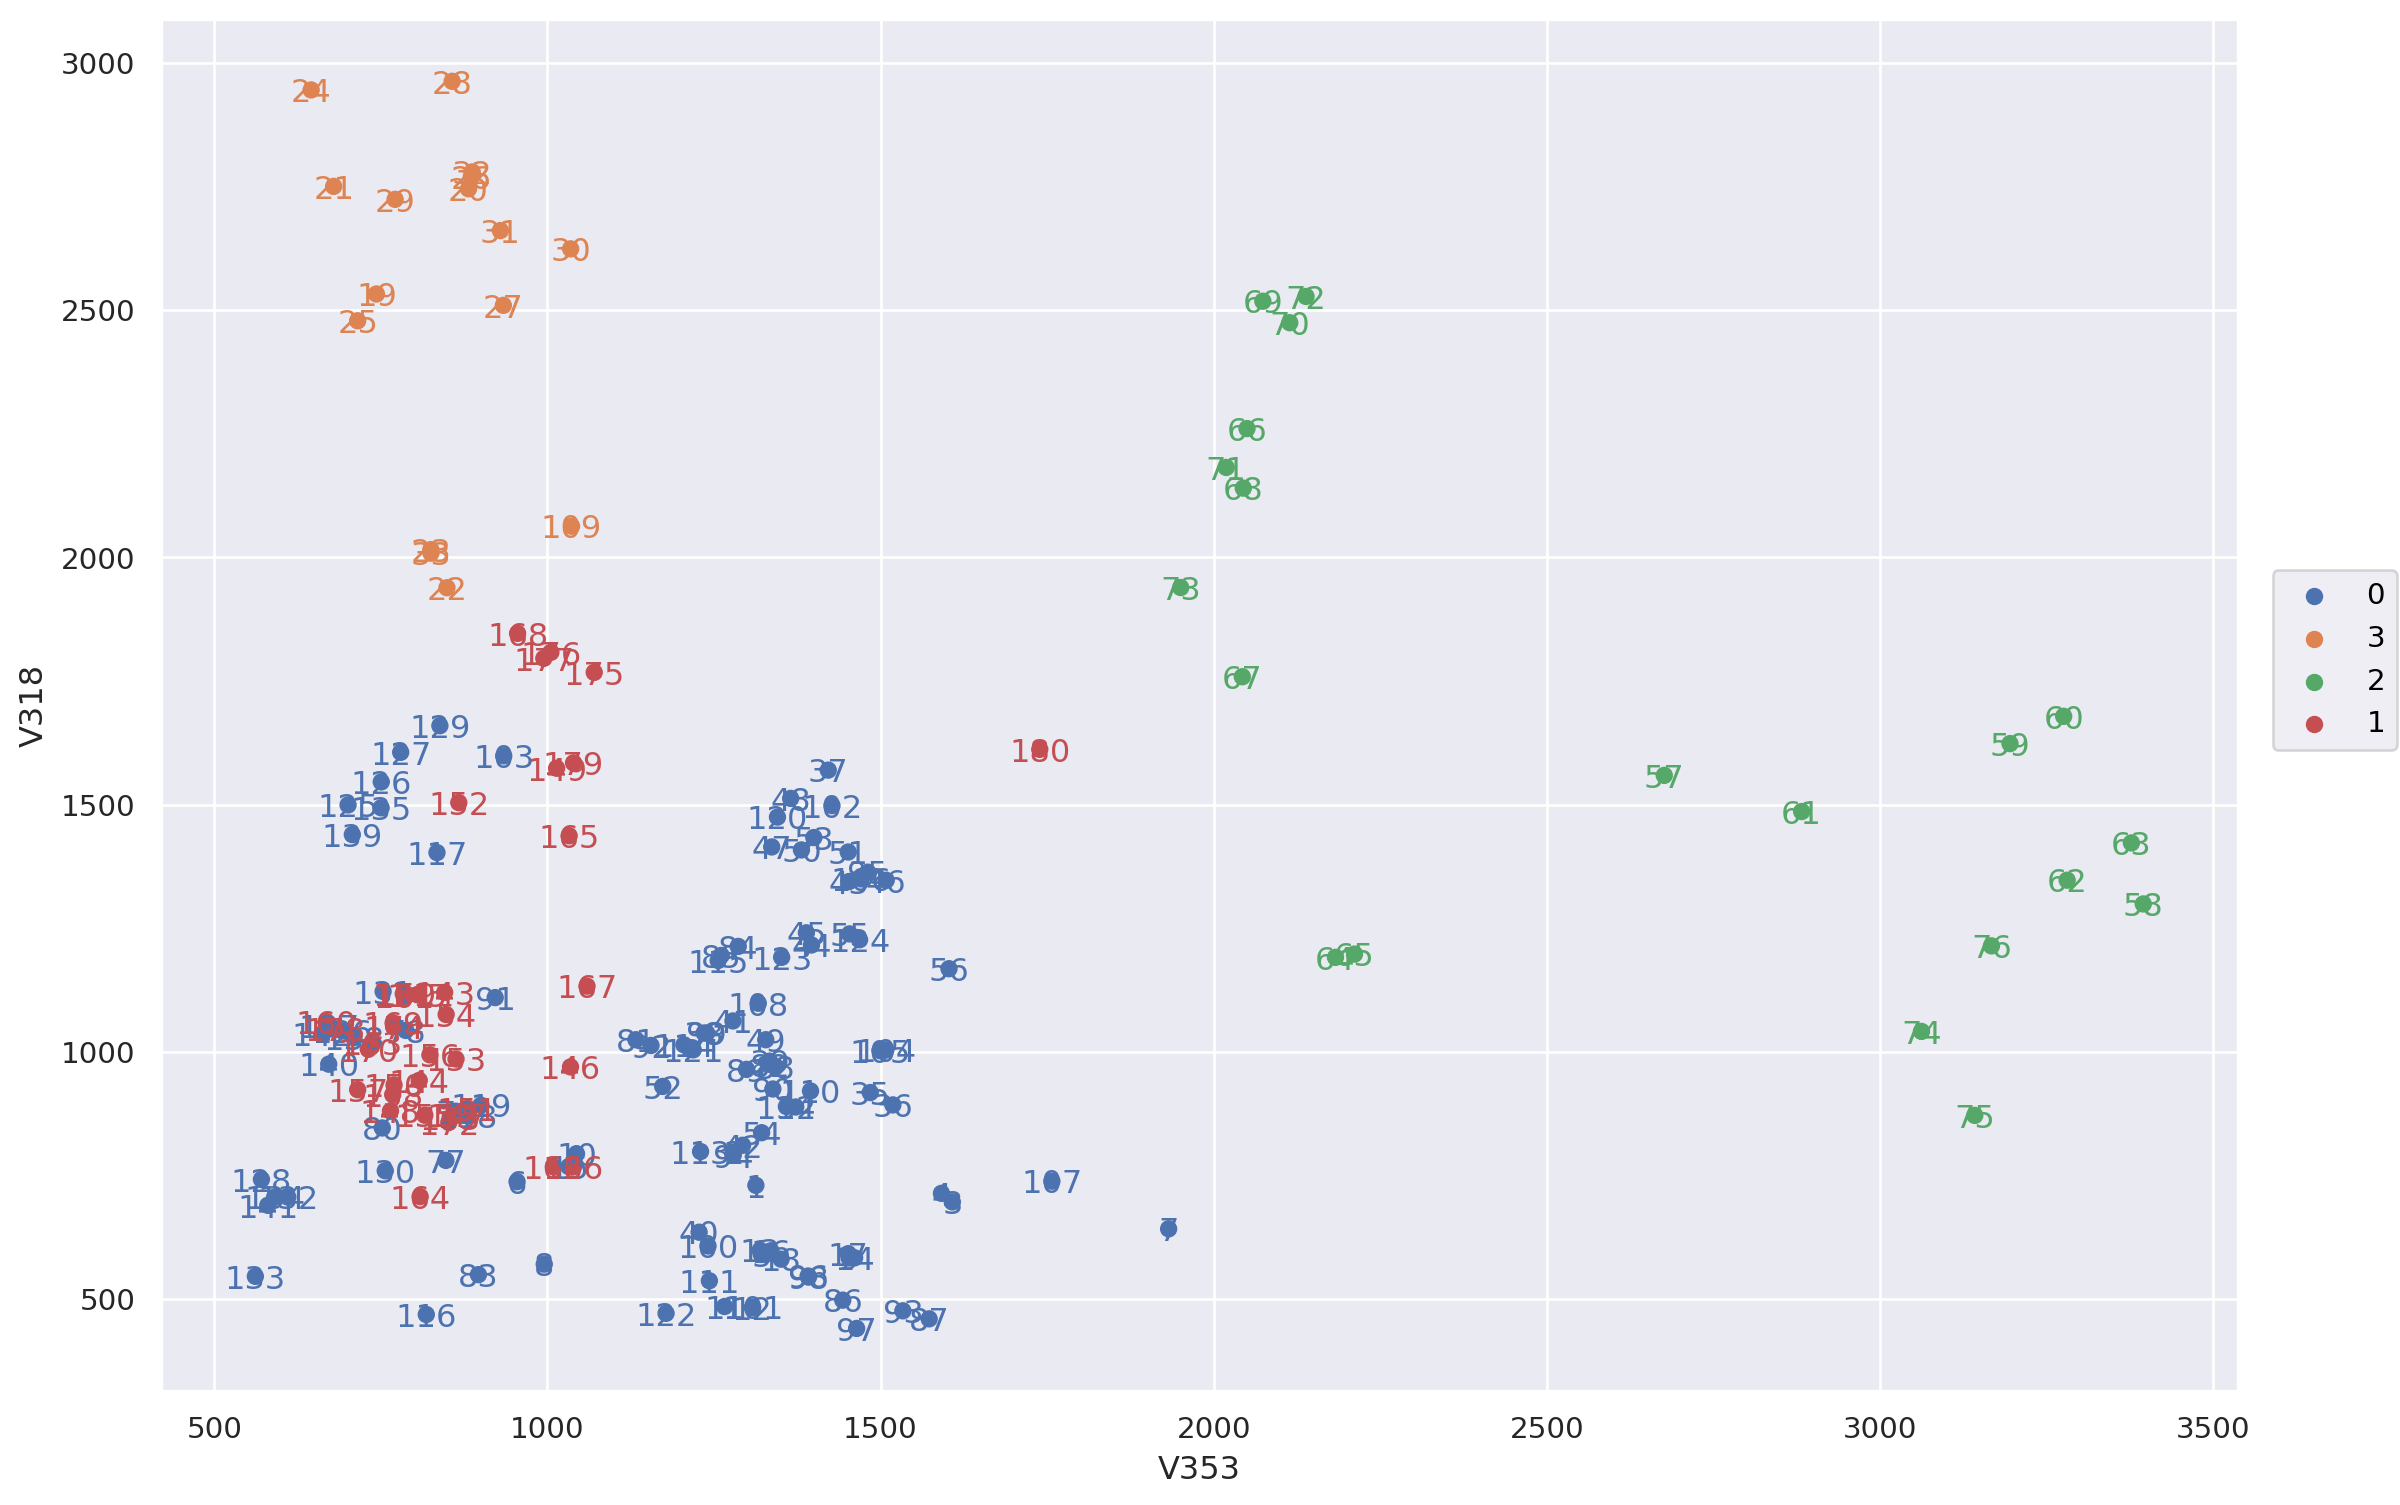

In [ ]:
V1 = "V353"
V2 = "V318"

# Graficamos
(
    so.Plot(data = dfx, x = V1, y = V2, text = dfx.index, color = labels.astype("str"))
    .add(so.Dot())
    .add(so.Text())
    .layout(size=(12,8))
)

Si aparecen dos clusters superpuestos podemos agregar una tercer variable.
Realizamos un gráfico 3D.

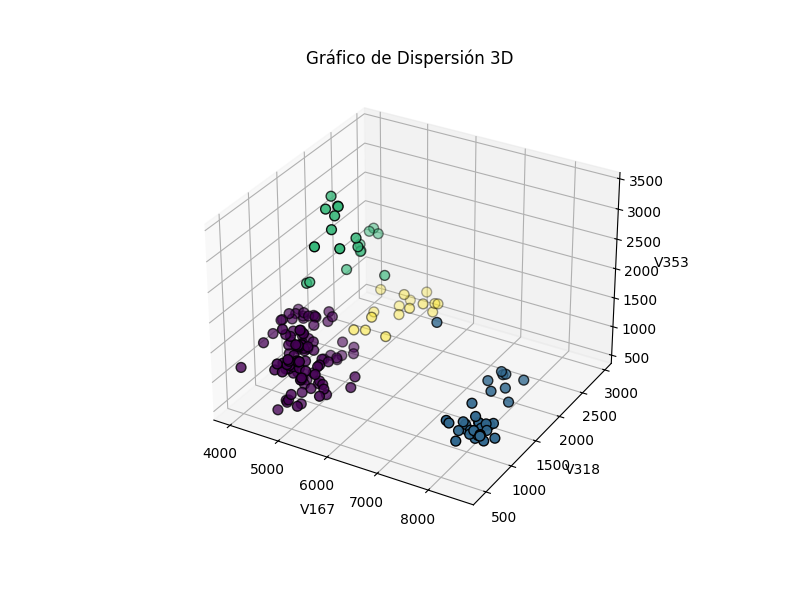

In [ ]:
%matplotlib widget

# Crear figura y ejes 3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

V1 = "V167";
V2 = "V318";
V3 = "V353";

# Scatter plot 3D
ax.scatter(dfx[V1], dfx[V2], dfx[V3], c=labels, edgecolor='k', s=50)

# Etiquetas de ejes
ax.set_xlabel(V1)
ax.set_ylabel(V2)
ax.set_zlabel(V3)

# Título
ax.set_title('Gráfico de Dispersión 3D')

plt.show()

Podemos ver qué pasa si tomamos 3 variables cualesquiera.

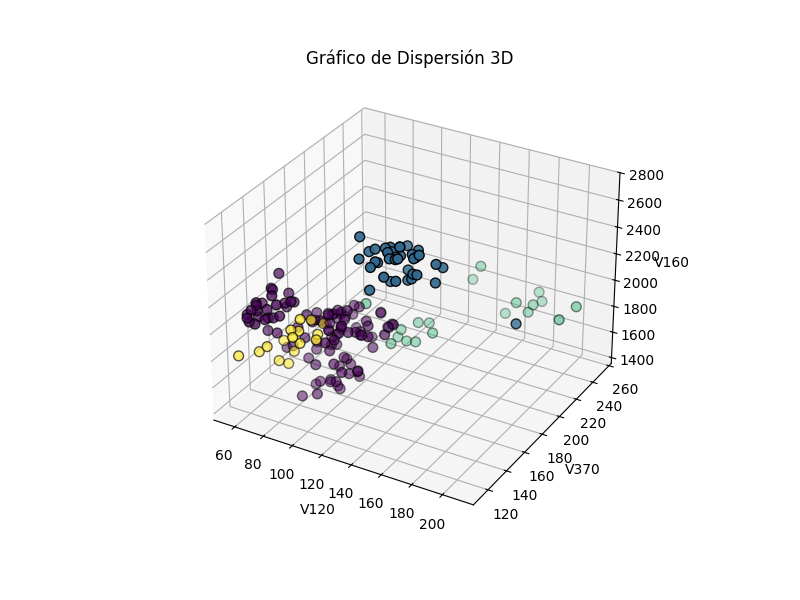

In [ ]:
# Crear figura y ejes 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

V1 = "V120";
V2 = "V370";
V3 = "V160";

# Scatter plot 3D
ax.scatter(dfx[V1], dfx[V2], dfx[V3], c=labels, edgecolor='k', s=50)

# Etiquetas de ejes
ax.set_xlabel(V1)
ax.set_ylabel(V2)
ax.set_zlabel(V3)

# Título
ax.set_title('Gráfico de Dispersión 3D')

plt.show()

No quedan bien separados los clusters.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

Automarizamos el proceso mediante componentes principales.

Veamos cuántas componentes tomar para explicar el 90% de la varianza de los datos.

In [ ]:
X_star = dfx - dfx.mean() # Normalizamos a media 0
X_star_t = np.transpose(X_star)
N = len(X_star)
Sigma = (X_star_t @ X_star) / N  # Matriz de covarianza

autovalores =  np.linalg.eigh(Sigma)[0]
autovalores

array([-2.35223685e-09, -1.83238200e-09, -1.45348400e-09, -9.10780863e-10,
       -8.28750880e-10, -8.21790482e-10, -7.25073267e-10, -6.52023918e-10,
       -5.72039597e-10, -5.27435370e-10, -3.95950475e-10, -3.20657208e-10,
       -3.16700843e-10, -2.83832320e-10, -2.32424411e-10, -2.22015873e-10,
       -2.12248039e-10, -1.91358194e-10, -1.90384475e-10, -1.74545323e-10,
       -1.70043211e-10, -1.61806413e-10, -1.53006006e-10, -1.50810216e-10,
       -1.26722504e-10, -1.22715616e-10, -1.09600877e-10, -1.05788472e-10,
       -1.04262358e-10, -1.02036183e-10, -9.62475643e-11, -7.94510920e-11,
       -7.66898553e-11, -7.16100833e-11, -7.07026268e-11, -6.80139966e-11,
       -6.10941938e-11, -5.57758409e-11, -5.15894636e-11, -4.72017547e-11,
       -4.71567830e-11, -4.50434706e-11, -4.28855485e-11, -4.16960231e-11,
       -4.09450740e-11, -3.50416075e-11, -3.36973270e-11, -2.97363448e-11,
       -2.96758647e-11, -2.75634797e-11, -2.62102612e-11, -2.30069180e-11,
       -2.03299375e-11, -

In [ ]:
# Varianza explicada por los últimos n autovalores
n = 3
autovalores[len(autovalores) - n:].sum()/autovalores.sum()  # la suma de los últimos n autovalores

np.float64(0.9899354864068646)

Con 3 compentes podemos explicar el 99% de la varianza en los datos!
Esto también coincide con los resultados del paper, hay 3 elementos químicos que aportan la mayor información.

Calculamos las 3 primeras componentes principales.

In [ ]:
n = 3
pca = PCA(n_components=n)

Z = pd.DataFrame(pca.fit_transform(dfx))

Z.columns = ["Z" + str(i) for i in range(1,n+1)]  # Renombramos las columnas
display(Z)

,Z1,Z2,Z3
0,-643.394365,-1261.536996,1007.689522
1,-876.085117,-1170.577585,797.509268
2,-2120.158267,-915.394061,1782.294966
3,-1892.409055,-932.920097,1696.399889
4,-220.176043,-1531.676132,1305.370337
...,...,...,...
175,7027.912512,2081.980796,-727.632092
176,7004.520851,2078.850994,-790.096059
177,7381.186386,-481.381465,-305.816849
178,6769.102579,1619.324403,-312.999384


Graficamos las vasijas según sus primero dos "puntajes".

Suele llamarse puntajes o scores a las coordenadas en las nuevas variables Z.
Por ejemplo si la primera componente agrupa las frecuencias que corresponden a vasijas "potásicas", la coordenada Z1 de una vasija indica qué tan potásica es la vasija.

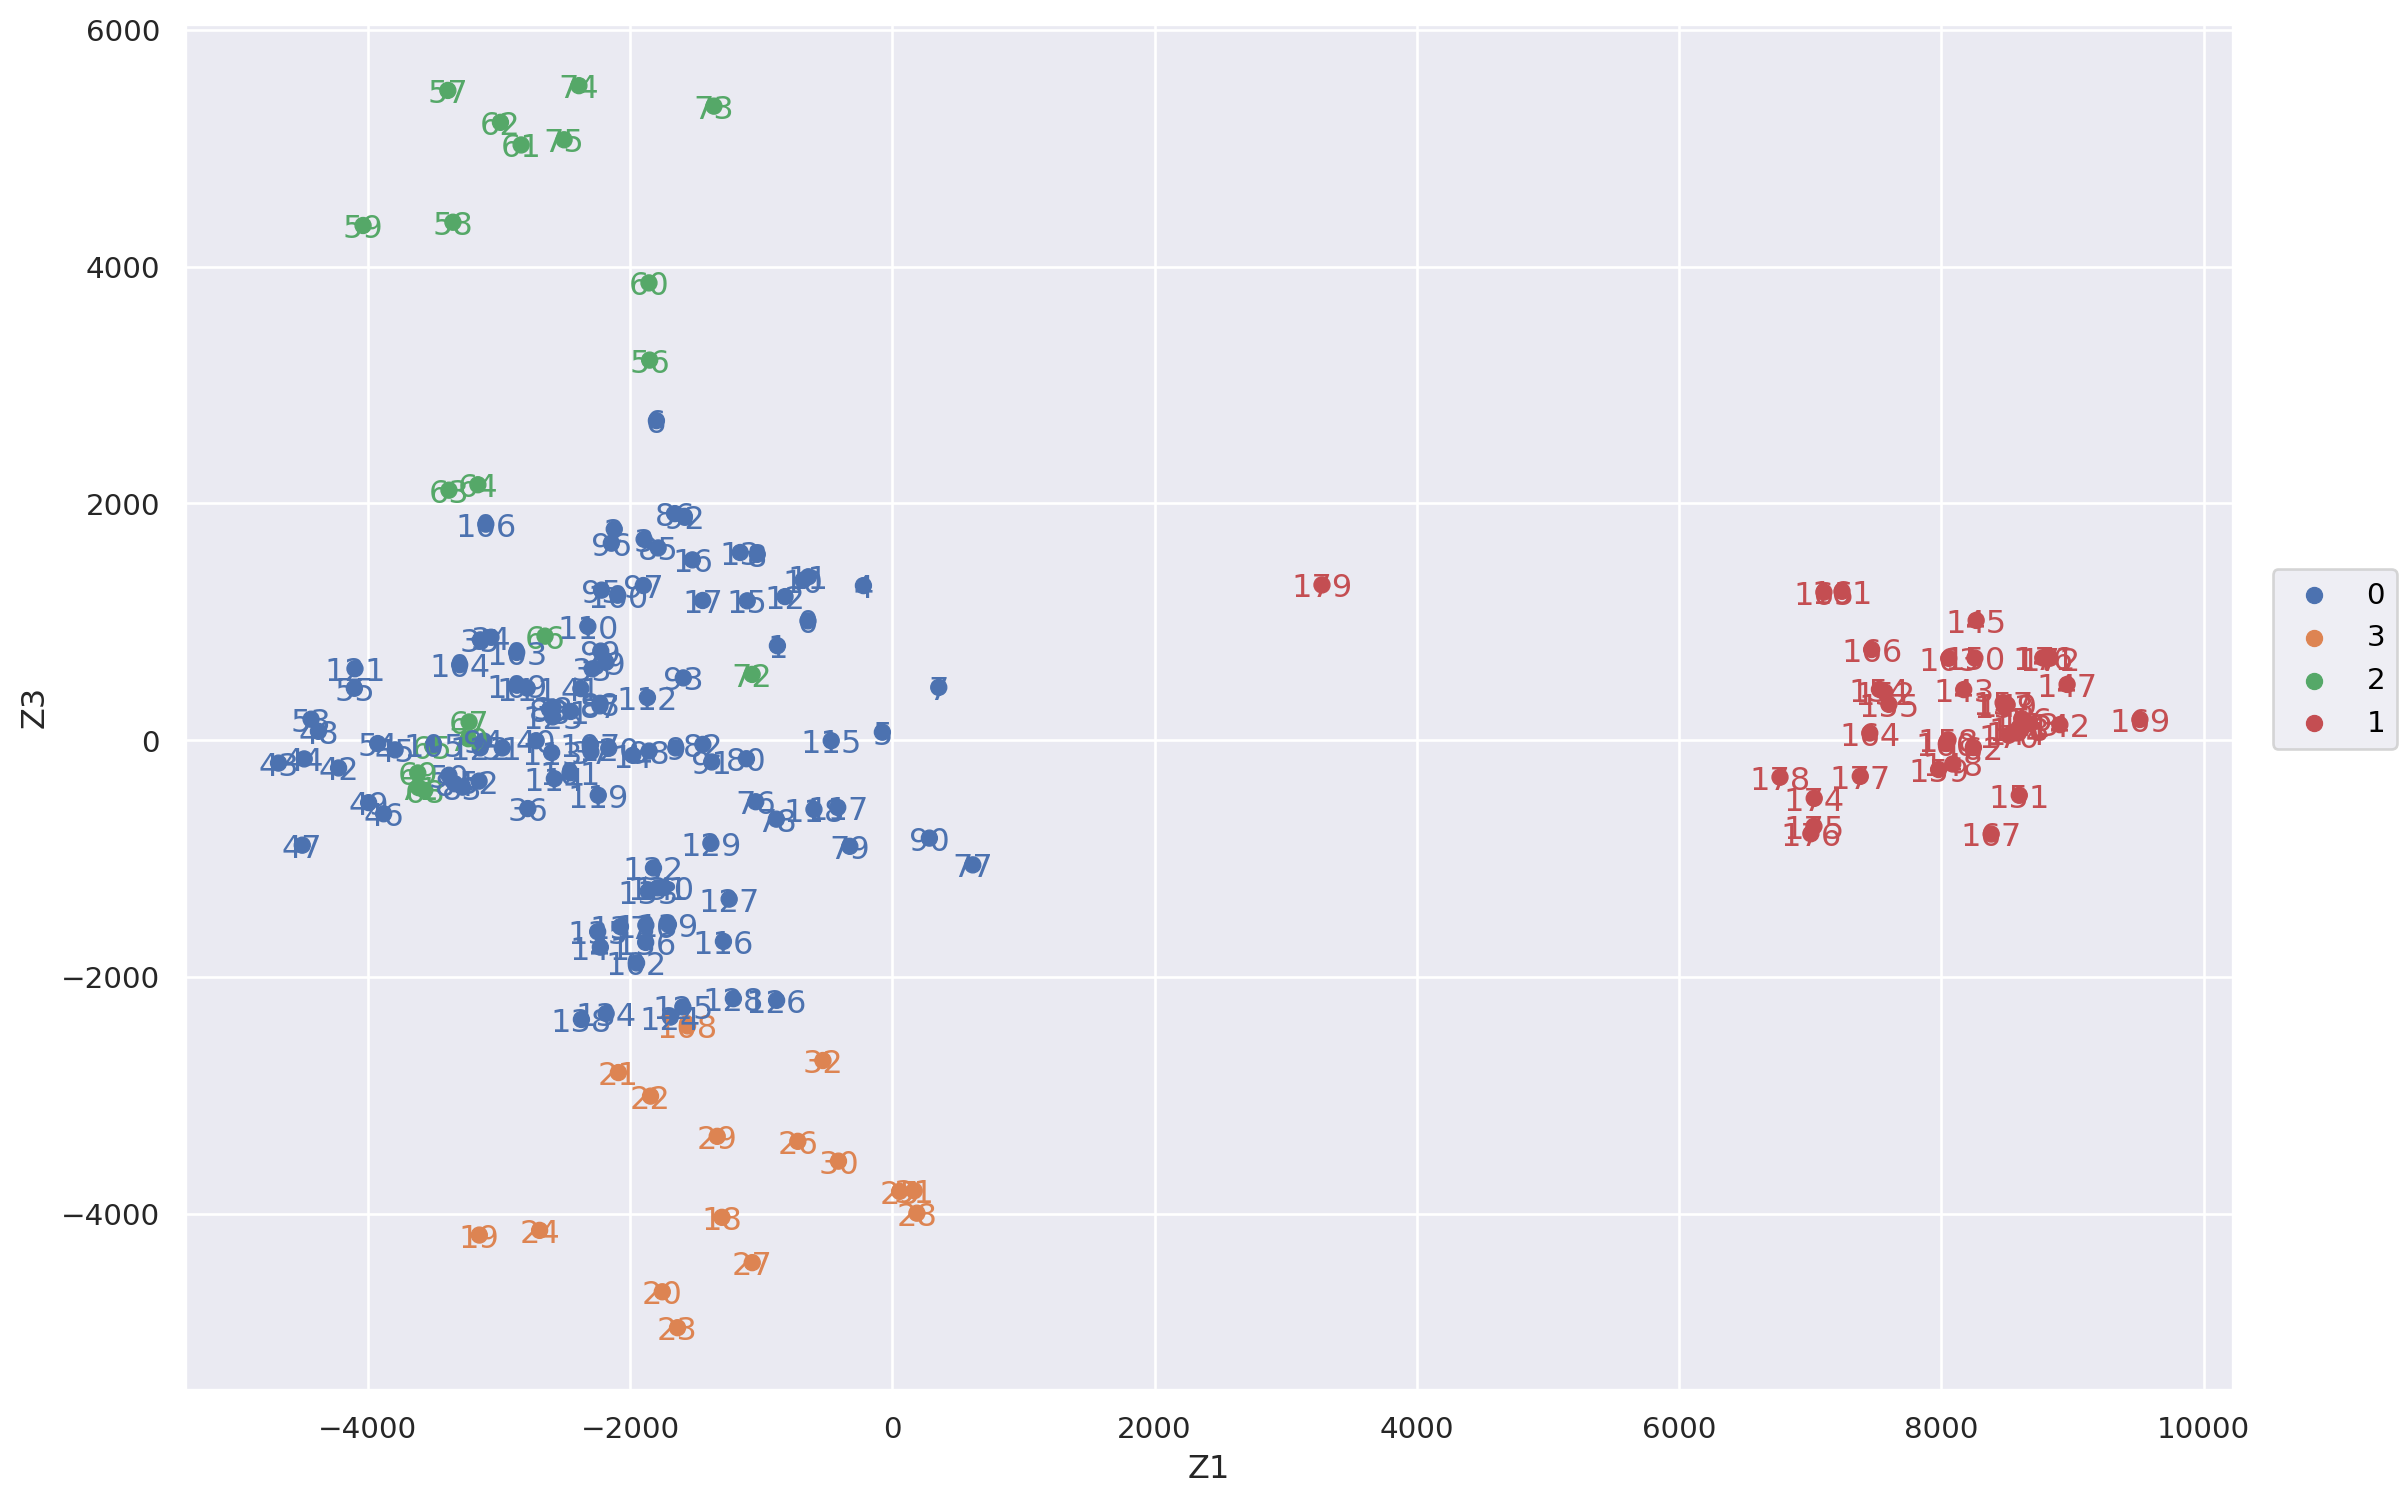

In [ ]:
# Graficamos
(
    so.Plot(data=Z, x="Z1", y="Z3", text = Z.index, color = labels.astype("str")) # labels = kmeans.labels_
    .add(so.Dot())
    .add(so.Text())
    .layout(size=(12,8))
)

Separa mejor que las variables que elegimos a mano, pero aparecen dos clusters superpuestos.
Agregamos la tercer componente.

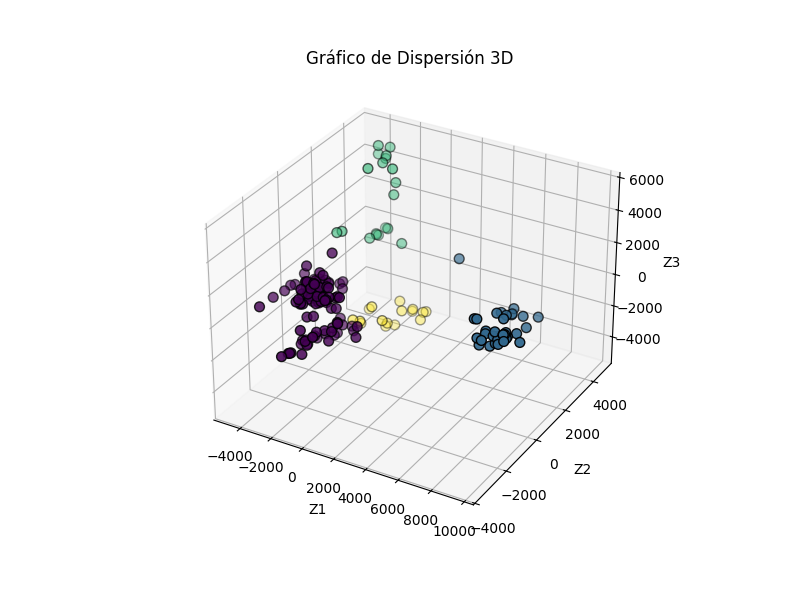

In [ ]:
# Crear figura y ejes 3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
ax.scatter(Z["Z1"], Z["Z2"],Z["Z3"], c = labels, edgecolor='k', s=50)

# Etiquetas de ejes
ax.set_xlabel('Z1')
ax.set_ylabel('Z2')
ax.set_zlabel('Z3')

# Título
ax.set_title('Gráfico de Dispersión 3D')

plt.show()

Vemos que los 4 grupos aparecen claramente separados, y fundamentalmente no tuvimos que suministrarle ninguna información, estamos efectivamente haciendo aprendizaje **no supervisado**.

Queremos ver ahora a que frecuencias corresponde cada componente.
Queremos graficar las **direcciones principales**, pero son vectores de 750 coordenadas!

Graficamos el "espectro" de cada dirección.

Ojo: esto no corresponden a vasija tipo 1, tipo 2 y tipo 3! Cómo podemos interpretar correctamente estos "espectros"?

In [ ]:
direcciones = pca.components_
direcciones

array([[-6.86284137e-22,  3.83685383e-23,  1.94295927e-08, ...,
        -4.04998985e-05,  2.24281576e-06,  1.90765720e-05],
       [ 9.79874204e-18, -7.50073003e-18, -5.96654077e-07, ...,
         1.01192837e-03,  1.04725043e-03,  7.51457404e-04],
       [ 5.66045444e-17, -6.01926745e-18,  1.31606781e-07, ...,
        -8.00439213e-05, -1.61178391e-04, -1.32508837e-04]])

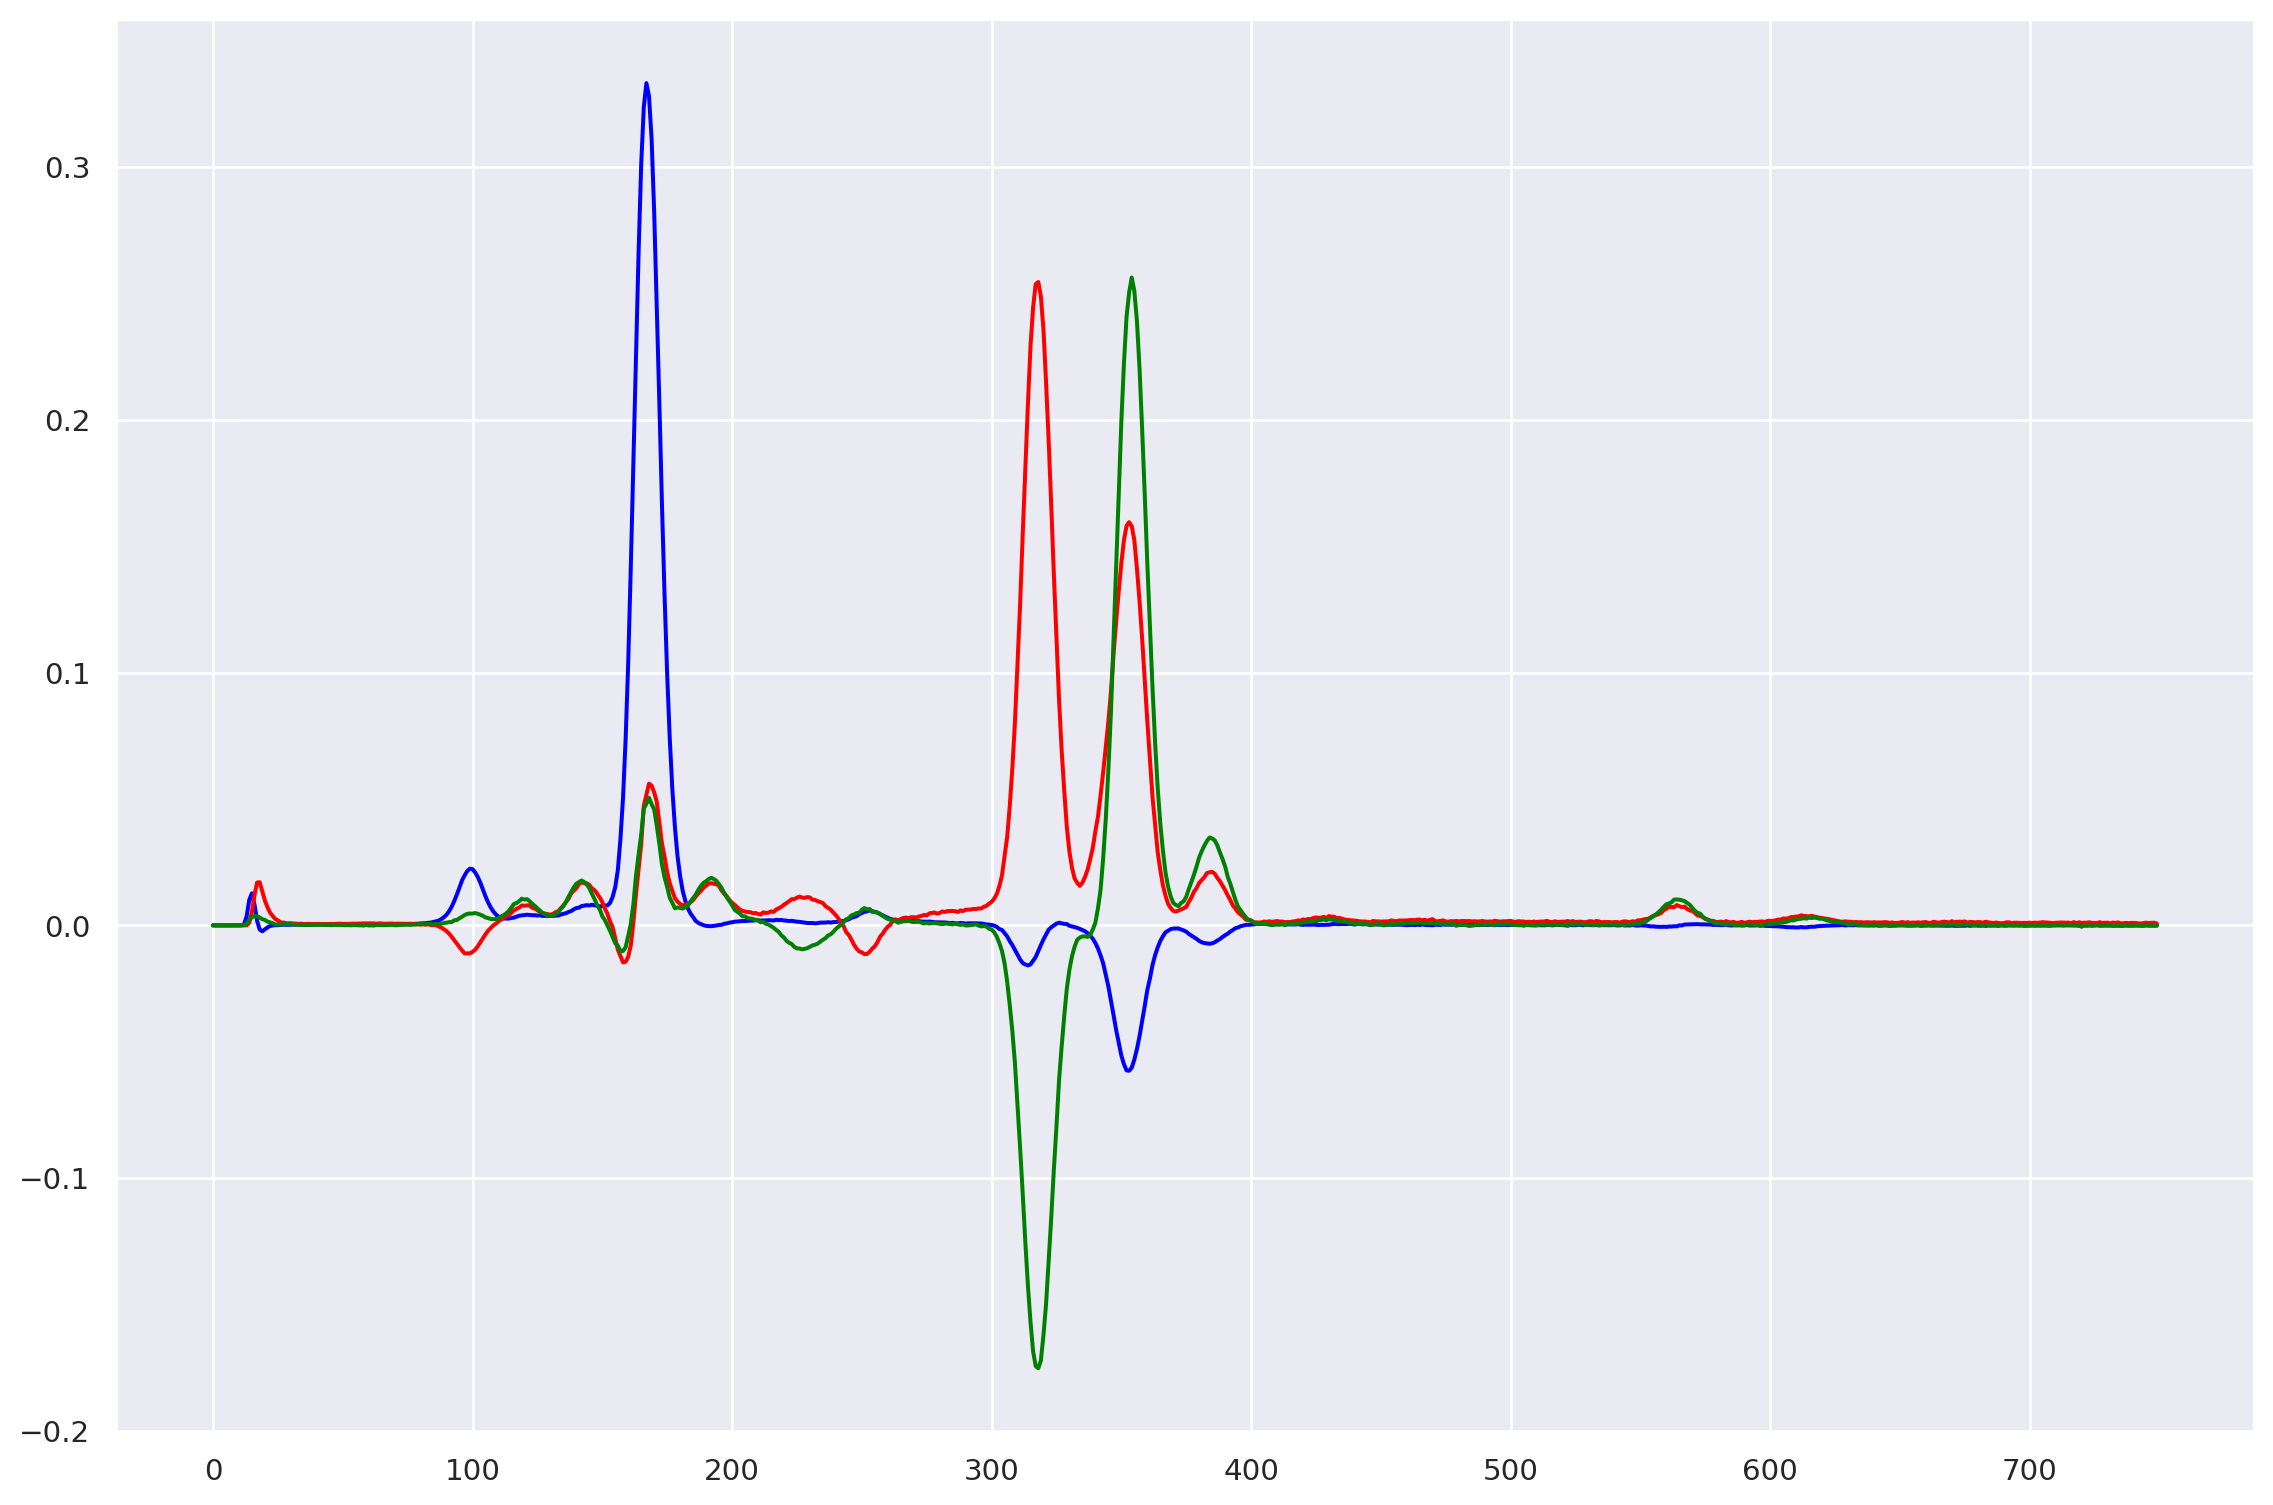

In [ ]:
# Graficamos las coordenadas de las direcciones princpales
(
    so.Plot(x = np.arange(0,750))
    .add(so.Line(color = "blue"), y = direcciones[0]) #V167
    .add(so.Line(color = "red"), y = direcciones[1]) #V318
    .add(so.Line(color = "green"), y = direcciones[2]) #V353
    .layout(size=(12,8))
)